In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import scipy.linalg as la
import scipy.stats as stats
import scipy.optimize as opt

In [4]:
from tqdm import tqdm

# 1. parameters

In [5]:
T = 120
N = 100000

In [6]:
d = 3
## order: 1, U, X, A, I
alpha = np.array([0, 0.5, 0, 1, 0])
# beta = np.array([1, -0.2, 0, 0, 0])
gamma = np.array([-2.5, 0, 0, 4, 100/N])
phi = 0.95

In [7]:
betas = np.array([
    np.linspace(1, 1.5, 21),     
    np.linspace(0, 0, 21),
    np.linspace(0, -1, 21),
]).T

$$P_t = 1 - \exp\{- \frac{\rho_t}{N} h I_t\}$$

$$\rho_t = \exp\{ - \beta_1 - \beta_A A_t - \beta_U U_t - \beta_X X_t \}$$

In [8]:
pC = 0.2
pD = 0.2

## seed values

In [9]:
I0 = 100
E0 = 0
S0 = N - E0 - I0

## simulation setting

In [10]:
num_beta = 21
num_sim = 1000

# 2. Fit

In [11]:
from sklearn.linear_model import LinearRegression, LogisticRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [12]:
import warnings
from statsmodels.tools.sm_exceptions import DomainWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DomainWarning)

In [13]:
bsim = np.zeros((num_beta,num_sim,d))

In [14]:
for iter_beta in tqdm(np.arange(num_beta), desc='beta', leave=None, position=0):
    data = pd.read_feather('data/simulation_phantom_%.2d.feather'%iter_beta)
    
    for iter_sim in tqdm(np.arange(num_sim), desc='SIM', leave=None, smoothing=0, position=0):
        try:
            # load data
            data_i = data[data['sim']==iter_sim]

            S = data_i.susceptible.values
            I = data_i.infected.values
            X = data_i.covariate.values
            A = data_i.intervention.values
            B = data_i.exposure.values

            # estimation of mu
            df_GLM = pd.DataFrame({
                # 'U': U[1:-2],
                'X': X[1:-2],
                'S': np.round(S[:-3]).astype(int),
                'B': np.round(B[1:-2]).astype(int),
                'A': A[1:-2],
                'offset': I[:-3] / N
            })
            df_GLM['log_offset'] = df_GLM['offset'].apply(lambda x: np.log(x) if x > 0 else np.log(1e-10))
            df_GLM['ratio'] = df_GLM['B']/df_GLM['S']

            model_GLM = smf.glm(formula='ratio ~ X + A', data=df_GLM, 
                                family=sm.families.Binomial(link=sm.families.links.Log()), 
                                offset=df_GLM['log_offset'], var_weights=df_GLM['S'])
            result_GLM = model_GLM.fit()

            bsim[iter_beta,iter_sim] = - result_GLM.params.values
        
        except:
            bsim[iter_beta,iter_sim] = None

beta: 100%|██████████| 21/21 [03:03<00:00,  8.74s/it]


# 3. Result

In [15]:
from matplotlib import ticker

In [16]:
bsim[np.abs(bsim) > 10] = None

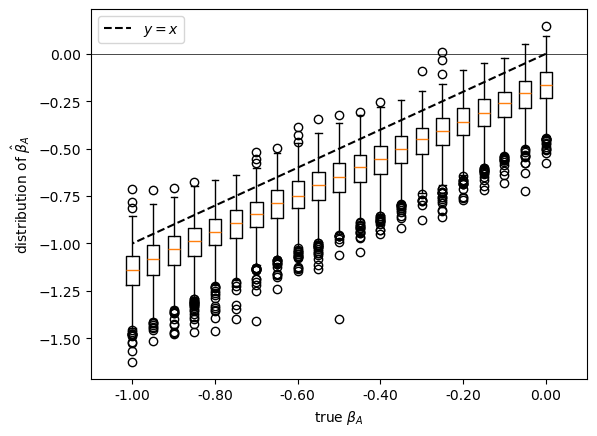

In [17]:
plt.boxplot([bs[~np.isnan(bs)] for bs in bsim[:,:,-1]], positions=betas[:,-1], widths=0.03)
plt.plot(betas[:,-1], betas[:,-1], linestyle='--', color='black', label=r'$y=x$')
plt.axhline(y=0, linewidth=0.5, color='black')
plt.xlim(np.min(betas[:,-1])-0.1, np.max(betas[:,-1])+0.1)
plt.xticks(np.linspace(np.min(betas[:,-1]), np.max(betas[:,-1]), 6), 
           np.linspace(np.min(betas[:,-1]), np.max(betas[:,-1]), 6))
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
plt.ylabel(r'distribution of $\hat\beta_A$'); plt.xlabel(r'true $\beta_A$'); plt.legend()
plt.show()

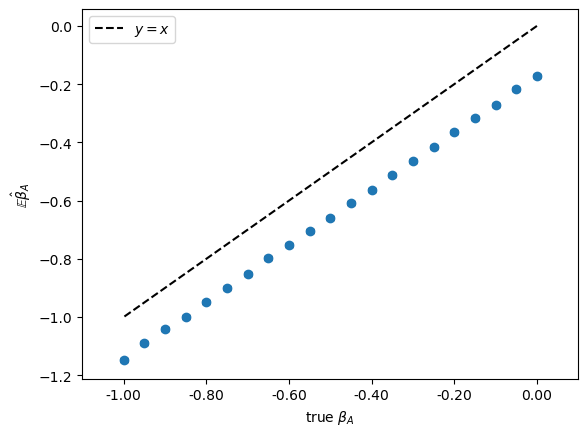

In [20]:
plt.errorbar(betas[:,-1], np.nanmean(bsim[:,:,-1], -1), yerr=2*np.nanstd(bsim[:,:,-1],-1)/np.sqrt(num_sim), 
             ecolor='black', capsize=3, fmt="o")
plt.plot(betas[:,-1], betas[:,-1], linestyle='--', color='black', label=r'$y=x$')
plt.xlim(np.min(betas[:,-1])-0.1, np.max(betas[:,-1])+0.1)
plt.xticks(np.linspace(np.min(betas[:,-1]), np.max(betas[:,-1]), 6), 
           np.linspace(np.min(betas[:,-1]), np.max(betas[:,-1]), 6))
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
plt.xlabel(r'true $\beta_A$'); plt.ylabel(r'$\mathbb{E}\hat\beta_A$'); plt.legend()
plt.show()